### Set up Pyro connection to the board
``soc`` and ``soccfg`` live on the board, and we interact with them through pyro proxy objects.  This section of code connects to the pyro server running on the board to receive these objects

In [1]:
## ------------------------------------------------ ##
import Pyro4
from qick import *

Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.137.93"
ns_port = 8883
proxy_name = "DMQIS_qick"
ns = Pyro4.locateNS(host=ns_host, port=ns_port)

for k,v in ns.list().items():
    print(k,v)

soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)
## ------------------------------------------------ ##

Pyro.NameServer PYRO:Pyro.NameServer@192.168.137.93:8883
DMQIS_qick PYRO:obj_8a18b384aecc4e1d939860471324ce0e@192.168.137.103:42509

QICK configuration:

	Board: ZCU216

	Software version: 0.2.257
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DA

c:\Users\slab.DESKTOP-JFLC5N4\radioconda\envs\DMQIS_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Basic Setup Parameters
Here we specify the channel connections between the fridge and the board.

I have set things up with the following configuration
* DAC 6: goes into warm splitter into fridge line A16
* DAC 2: goes into warm splitter into fridge line A16
* ADC 0: comes out of fridge line C7

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qick import *
import sys
sys.path.append('./Libraries')
from qick_data import *
from qick_helpers import *
from qick_programs import *
import time
import tqdm


datapath = 'c:\\_Data\\Hannah\\SQUAT_Rabi'

### Quick Frequency Scan

In [10]:
## Initialize a measurement object
## This object holds dictionaries
## Not much else to it.  Just a container that handles export/import
meas = QICKdata()

## Next we fill the metadata dictionary
meas.set_metadata(device="C11", qubits=["1"], meas_type="freq_scan")

## Then specify the connection channels
meas.set_hw_cfg(res_ch=chargebias_ch, qu_ch=None, ro_ch=ro_ch)
#meas.hw_cfg["LO_power"] = 16
#meas.hw_cfg["LO_freq"] = 4500
## Finally specify pulse parameters
meas.meas_cfg = {"relax_delay_us" : 0,
            "adc_trig_offset_us"  : 0.506,
            "readout_length_us"   : 20, #0.2,
   
            "res_style" : "const",
            "res_gain"      : 5000, #30000,
            "res_length_us" : 20, #0.279,
            "res_phase"     : 0,
            ## commenting out because this is a freq scan
            ## "res_freq" : 3000, ## MHz

            "reps"          : 700,   ## Averages in firmware
            "soft_avgs"     : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
RF_freqs = np.linspace(7340, 7370, num=500)
Ivals = np.zeros(len(RF_freqs))
Qvals = np.zeros(len(RF_freqs))

## Initialize a program
## Give it config dictionaries from the measurement class
config = {**meas.hw_cfg, **meas.meas_cfg}
for i, f in enumerate(RF_freqs):
    config["res_freq"] = f
    prog =oneTonePulse(soccfg, config)
    [[I]], [[Q]] = prog.acquire(soc)
    Ivals[i] = I
    Qvals[i] = Q

##  IMPORTANT make sure you save the data
meas.meas_data = {"RF_freqs" : RF_freqs, "Ivals" : Ivals, "Qvals" : Qvals}
meas.write_H5('c:\\_Data\\Hannah\\SQUAT_freqscan')

Creating dataset with series 20240517_133205
converting time variables from us to clock ticks
====---------------------------====
         20240517_133205
====---------------------------====
       Device =  C11
       Qubits =  ['1']
    Meas Type =  freq_scan
====---------------------------====
20240517_133205
Saving data as: 20240517_133205_freq_scan.h5


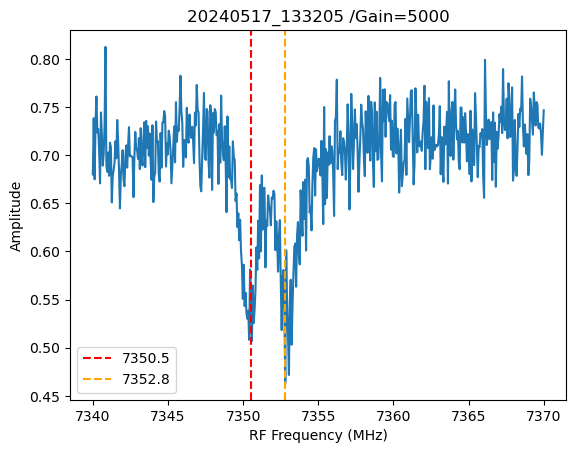

In [14]:
m1 = 7350.5
m2 = 7352.8

plt.plot(RF_freqs, np.sqrt(Ivals**2 + Qvals**2))
#plt.axvline(7358, color='r', linestyle='--', label='7350MHz')
plt.xlabel('RF Frequency (MHz)')
plt.ylabel('Amplitude')
plt.axvline(m1, color='r', linestyle='--', label=str(m1))
plt.axvline(m2, color='orange', linestyle='--', label=str(m2))
plt.legend()
plt.title(meas.meta['series'] + " /Gain=" + str(meas.meas_cfg['res_gain']))
plt.savefig('c:\\_Data\\Hannah\\SQUAT_freqscan' + '\\' + meas.meta['series'] + '_.png')

# Then Rabi at the desired frequency

In [17]:
## Initialize a measurement object
## This object holds dictionaries
## Not much else to it.  Just a container that handles export/import
meas = QICKdata()

## Next we fill the metadata dictionary
meas.set_metadata(device="C11", qubits=["1"], meas_type="rabi_1D")

## Then specify the connection channels
meas.set_hw_cfg(res_ch=chargebias_ch, qu_ch=None, ro_ch=ro_ch)
meas.hw_cfg["warm_att"] = 0
meas.hw_cfg["channel"] = "TL"

## Finally specify pulse parameters
meas.meas_cfg = {"relax_delay_us" : 1,
            "adc_trig_offset_us"  : 0.506,
            #"readout_length_us"   : 2, #0.2,
   
            "res_style" : "const",
            "res_gain"      : 5000, #30000,
            #"res_length_us" : 2, #0.279,
            "res_phase"     : 0,
            "res_freq" : m1, ## MHz

            "reps"          : 40000,   ## Averages in firmware
            "soft_avgs"     : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
lengths_us = np.linspace(0.01, 15, num=800)
lengths_clock_ticks = np.zeros(len(lengths_us))
for i, l in enumerate(lengths_us):
    lengths_clock_ticks[i] = soccfg.us2cycles(l)

## Set up data arrays
Ivals = np.zeros(len(lengths_clock_ticks))
Qvals = np.zeros(len(lengths_clock_ticks))

config = {**meas.hw_cfg, **meas.meas_cfg}

for  j, l in enumerate(tqdm.tqdm(lengths_clock_ticks)):
    config['res_length'] = l
    config['readout_length'] = l
    prog =oneTonePulse(soccfg, config)
    [[I]], [[Q]] = prog.acquire(soc)
    Ivals[j] = I
    Qvals[j] = Q

##  IMPORTANT make sure you save the data
meas.meas_data = {"lengths_us" : lengths_us, "lengths_clock_ticks": lengths_clock_ticks,"Ivals" : Ivals, "Qvals" : Qvals,}
meas.write_H5(datapath)


Creating dataset with series 20240512_143710
converting time variables from us to clock ticks
====---------------------------====
         20240512_143710
====---------------------------====
       Device =  C11
       Qubits =  ['1']
    Meas Type =  rabi_1D
====---------------------------====
20240512_143710


100%|██████████| 800/800 [06:32<00:00,  2.04it/s]

Saving data as: 20240512_143710_rabi_1D.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


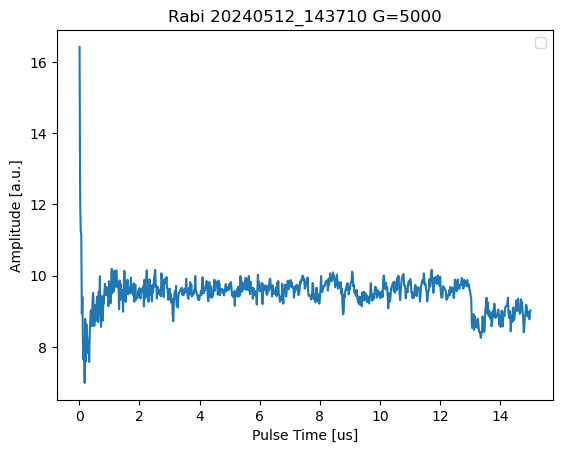

In [18]:
amps = np.zeros(len(Ivals))
amps_norm = np.zeros(len(Ivals))
for i in range(len(Ivals)):
    amps[i] = np.sqrt(Ivals[i]**2 + Qvals[i]**2)
    #amps_norm[i] = amps[i] / lengths_clock_ticks[i]


plt.plot(lengths_us, amps)
#plt.plot(lengths_us, Ivals)
#plt.plot(lengths_us, Qvals)
plt.xlabel('Pulse Time [us]')
plt.ylabel('Amplitude [a.u.]')
plt.legend()
plt.title("Rabi " + meas.meta['series'] + " G=" +str(meas.meas_cfg['res_gain']))
plt.savefig(datapath + '\\' + meas.meta['series'] + '_rabi_1D.png')
plt.show()

# Fixed readout window Rabi

In [34]:
## Initialize a measurement object
## This object holds dictionaries
## Not much else to it.  Just a container that handles export/import
meas = QICKdata()

## Next we fill the metadata dictionary
meas.set_metadata(device="C11", qubits=["1"], meas_type="rabi_1D_fixed_roTime")

## Then specify the connection channels
meas.set_hw_cfg(res_ch=transmission_ch, qu_ch=None, ro_ch=ro_ch)


## Finally specify pulse parameters
meas.meas_cfg = {"relax_delay_us" : 0.5,
            "adc_trig_offset_us"  : 0.506,
            "readout_length_us"   : 0.2,
   
            "res_style" : "const",
            "res_gain"      : 30000, #30000,
            #"res_length_us" : 2, #0.279,
            "res_phase"     : 0,
            "res_freq" : m1, ## MHz

            "reps"          : 20000,   ## Averages in firmware
            "soft_avgs"     : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
lengths_us = np.linspace(0.01, 30, num=1000)
lengths_clock_ticks = np.zeros(len(lengths_us))
for i, l in enumerate(lengths_us):
    lengths_clock_ticks[i] = soccfg.us2cycles(l)

## Set up data arrays
Ivals = np.zeros(len(lengths_clock_ticks))
Qvals = np.zeros(len(lengths_clock_ticks))

config = {**meas.hw_cfg, **meas.meas_cfg}

for  j, l in enumerate(tqdm.tqdm(lengths_clock_ticks)):
    config['res_length'] = l
    if l < config['readout_length']:
        config['adc_trigger_offset'] = soccfg.us2cycles(0.506)
    else:
        config['adc_trigger_offset'] = soccfg.us2cycles(0.506) + l - config['readout_length']
    prog =oneTonePulse(soccfg, config)
    [[I]], [[Q]] = prog.acquire(soc)
    Ivals[j] = I
    Qvals[j] = Q

##  IMPORTANT make sure you save the data
meas.meas_data = {"lengths_us" : lengths_us, "lengths_clock_ticks": lengths_clock_ticks,"Ivals" : Ivals, "Qvals" : Qvals,}
meas.write_H5(datapath)

Creating dataset with series 20240513_140247
converting time variables from us to clock ticks
====---------------------------====
         20240513_140247
====---------------------------====
       Device =  C11
       Qubits =  ['1']
    Meas Type =  rabi_1D_fixed_roTime
====---------------------------====
20240513_140247


 59%|█████▊    | 587/1000 [01:55<01:21,  5.08it/s]


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


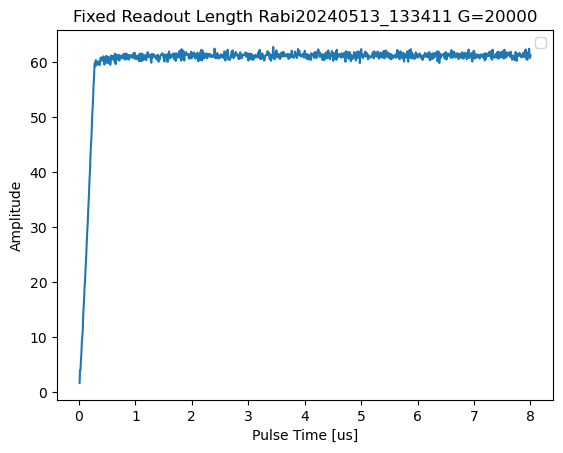

In [33]:

plt.plot(lengths_us, np.sqrt(Ivals**2 + Qvals**2))
#plt.axvline(7358, color='r', linestyle='--', label='7350MHz')
plt.xlabel('Pulse Time [us]')
plt.ylabel('Amplitude')
plt.legend()
plt.title("Fixed Readout Length Rabi" + meas.meta['series'] + " G=" +str(meas.meas_cfg['res_gain']))
plt.savefig(datapath + '\\' + meas.meta['series'] + 'rabi1_notNormalized_.png')

# Readin

Reading from filepath c:\_Data\Hannah\SQUAT_Rabi
Creating dataset with series 20240504_200731
====---------------------------====
         20240504_200731
====---------------------------====
       Device =  C11
       Qubits =  [1.]
    Meas Type =  rabi_freq_len
====---------------------------====
20240504_200731


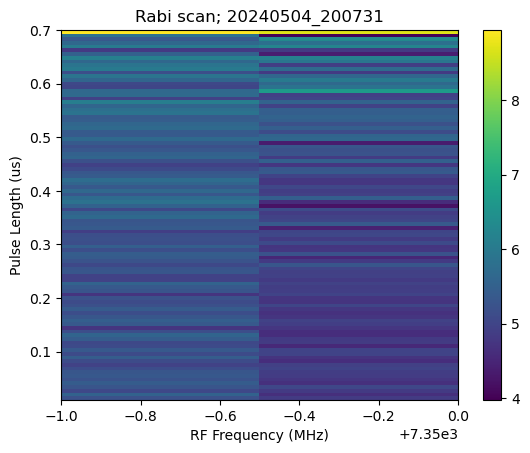

In [30]:
readin = read_H5(datapath, "20240504_200731_rabi_freq_len.h5", QICKdata)
print(readin)
norm_amps = np.abs(readin.meas_data["Ivals"] + 1j*readin.meas_data["Qvals"]) / readin.meas_cfg["readout_length"]
plt.imshow(amps, aspect='auto', extent=[readin.meas_data["RF_freqs"][0], readin.meas_data["RF_freqs"][-1], readin.meas_data["lengths_us"][0], readin.meas_data["lengths_us"][-1]])
plt.colorbar()
plt.xlabel("RF Frequency (MHz)")
plt.ylabel("Pulse Length (us)")
plt.title(f"Rabi scan; {readin.meta['series']}")
plt.savefig(datapath + f"\\{readin.meta['series']}_Rabi_freq_len.png")
plt.show()
